In [ ]:
# 적용 가능 문제
### 매장 배분 문제 (매장 재고 최적화)
### 리오더 문제 (몬테카를로 시뮬레이션이 아니라, 판매 예측 범위 적용으로 변경해야 함 _과장님하신 prophet)
-> 이익 최대화하는 리오더 포인트, 오더 수량 결정
-> 리드타임 별 cost도 반영 가능
https://github.com/wiredtoserve/datascience/blob/master/InventoryManagement/inventory_management.ipynb

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [2]:
import operator

In [3]:
summary = pd.read_csv('summary_stats.csv')
df = pd.read_excel('XYZ-1.xlsx', 'Data')
demand = df[6:]

In [4]:
summary

,Purchase Cost,Lead Time,Size,Selling Price,Starting Stock,Mean,Std Dev,Co,Ch,Probability,Demand_lead
0,12,9,0.570,16.1,2750,103.501805,37.317994,1000,20,0.756831,705
1,7,6,0.052,8.6,22500,648.551913,26.446797,1200,20,1.000000,3891
2,6,16,0.530,10.2,5200,201.677043,31.079301,1000,20,0.702186,2266
3,37,22,1.050,68.0,1400,150.068965,3.215598,1200,20,0.237705,785


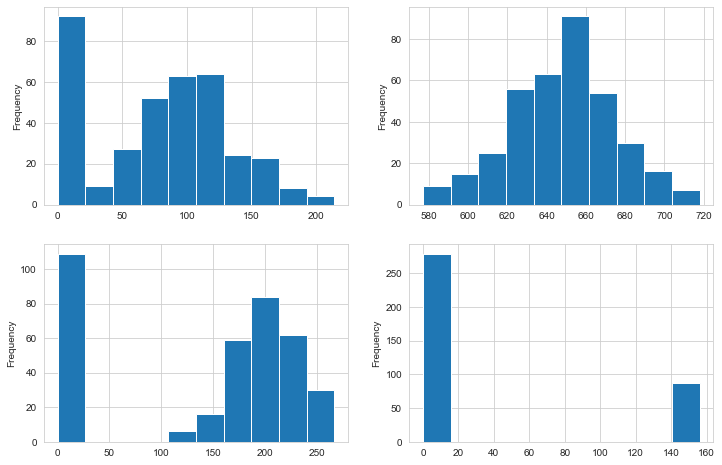

In [5]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
demand[1].plot.hist(ax=axes[0,0])
demand[2].plot.hist(ax=axes[0,1])
demand[3].plot.hist(ax=axes[1,0])
demand[4].plot.hist(ax=axes[1,1])

In [6]:
class Product:
    def __init__(self, i):
        # i = product number
        self.i = i
        self.unit_cost = summary['Purchase Cost'].iloc[i-1]
        self.lead_time = summary['Lead Time'].iloc[i-1]
        self.size = summary['Size'].iloc[i-1]
        self.selling_price = summary['Selling Price'].iloc[i-1]
        self.holding_cost = summary['Ch'].iloc[i-1]
        self.ordering_cost = summary['Co'].iloc[i-1]
        self.probability = summary['Probability'].iloc[i-1]
        self.starting_stock = summary['Starting Stock'].iloc[i-1]
        self.demand_lead = summary['Demand_lead'].iloc[i-1]
        
        self.mean = np.mean([np.log(j) for j in demand[demand[i] > 0][i]])
        self.sd = np.std([np.log(j) for j in demand[demand[i] > 0][i]])        

In [7]:
# Drawing from a log normal distribution
# 이 demand 함수를 prophet 모델 돌린 결과를 가져다 쓰면 어떠려나!

def daily_demand(mean, std, probability):
    random_num = np.random.uniform(0,1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, std))

In [8]:
# Simulating a Monte Carlo ray for 1 year
# M = replenishment level

def monte_carlo_ray(M, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    
    q = 0
    stock_out = 0
    data = {'inv_level':[], 'daily_demand':[], 'units_sold':[], 'units_lost':[], 'orders':[]}
    
    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)
        
        if day % (review_period + lead_time) == 0:
            q = M - inventory
            data['orders'].append(q)
            inventory += q
            
        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1
            
        data['inv_level'].append(inventory)
        
    return data

In [9]:
# newer version

def monte_carlo_ray(M, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.demand_lead
    
    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    
    data = {'inv_level':[], 'daily_demand':[], 'units_sold':[], 'units_lost':[],'orders':[]}
    
    for day in range(1,365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)
        
        if day % review_period == 0:
            q = M - inventory + demand_lead
            order_placed = True
            data['orders'].append(q)
            
        if order_placed:
            counter += 1
            
        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0
            
        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
            
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand-inventory)
            inventory = 0
            stock_out += 1
            
        data['inv_level'].append(inventory)
        
    return data

In [10]:
def calculate_profit(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365
    
    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1/days)
    cost = sum(data['orders']) * unit_cost
    
    profit = revenue - cost - Co - Ch
    
    return profit

In [11]:
def mc_simulation(product, M, num_simulations=100):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = monte_carlo_ray(M, product)
        profit = calculate_profit(data, product)
        profit_list.append(profit)
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)
        
    return profit_list, orders_lost_list

In [12]:
product_1 = Product(1)
p_list = mc_simulation(product_1, 3000, 1000)
print([np.mean(p_list), np.std(p_list)])

[39020.8757477961, 39220.704118418005]


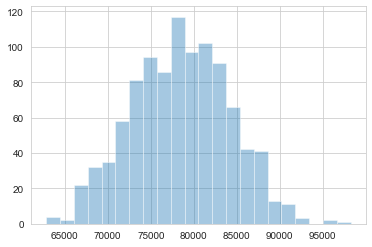

In [13]:
p_list, o_list = mc_simulation(Product(1), 3000, 1000)
sns.distplot(p_list, kde=False)
plt.show()

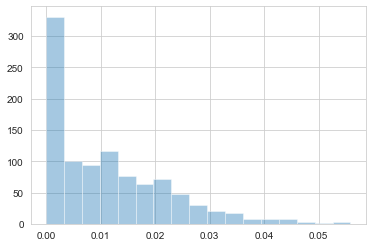

In [15]:
sns.distplot(o_list, kde=False)
plt.show()

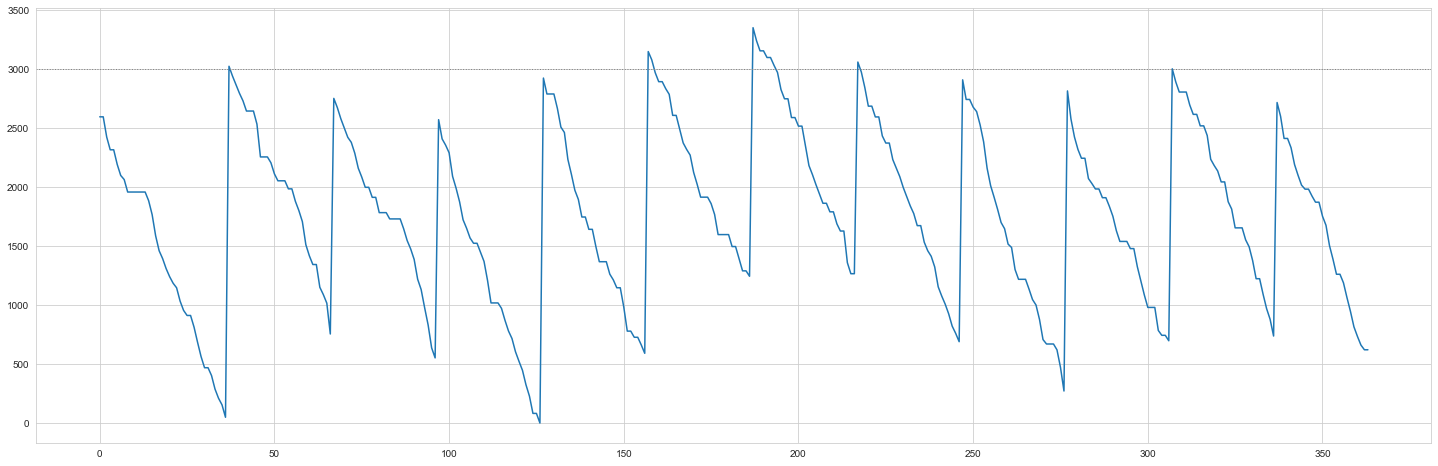

In [16]:
data = monte_carlo_ray(3000, product_1)
plt.figure(figsize=(25,8))
plt.plot(data['inv_level'])
plt.axhline(3000, linewidth=1, color='grey', linestyle=':')
plt.show()

In [17]:
def periodic_review(product, low, high, step=50):
    m_range = [i for i in range(low, high, step)]
    review_dict = {}
    
    for M in m_range:
        p_list, o_list = mc_simulation(product, M)
        review_dict[M] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))
        
    return review_dict

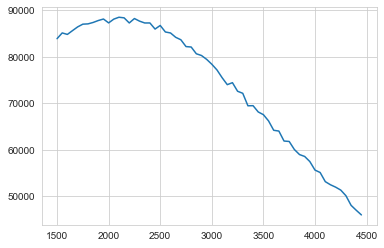

In [18]:
review = periodic_review(Product(1), 1500, 4500)
xx = [i for i in review.keys()]
yy = []

for val in review.values():
    yy.append(val[0])
    
plt.plot(xx, yy)
plt.show()

In [19]:
max(review.items(), key=operator.itemgetter(1))

(2100,
 (88532.7028335063,
  81611.81448300183,
  95658.05586910101,
  4179.10601359993,
  0.07549297570883307))

In [34]:
# creating a dataframe with all the results
idx = ['Order-point M', 'Expected Profit', 'Profit Standard Deviation', 'Proportion of Lost Orders']
review = periodic_review(Product(1), 2500, 4000, 10)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))

review = periodic_review(Product(2), 23000, 24000, 10)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))

review = periodic_review(Product(3), 6200, 6800, 10)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))

review = periodic_review(Product(4), 2000, 2400, 10)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))

df_product_review = pd.DataFrame(
    {'1': [prod_review_1[0], prod_review_1[1][0], prod_review_1[1][3], prod_review_1[1][4]],
    '2': [prod_review_2[0], prod_review_2[1][0], prod_review_2[1][3], prod_review_2[1][4]],
    '3': [prod_review_3[0], prod_review_3[1][0], prod_review_3[1][3], prod_review_3[1][4]],
    '4': [prod_review_4[0], prod_review_4[1][0], prod_review_4[1][3], prod_review_4[1][4]],
    })

In [39]:
df_product_review.index = idx
df_product_review

,1,2,3,4
Order-point M,2500.000000,23000.000000,6220.000000,2100.000000
Expected Profit,86698.441860,341518.698484,143168.535603,302563.748640
Profit Standard Deviation,4733.840709,911.048412,8880.984291,36679.670965
Proportion of Lost Orders,0.030520,0.000000,0.020343,0.030131


In [43]:
def p_review_optimum(product, M, sim=1000):
    review_dict = {}
    p_list, o_list = mc_simulation(product, M, sim)
    review_dict[M] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))
    return review_dict

In [44]:
# optimum 어뜨케 찾앙..?

# Product 1: 2071
# Product 2: 18424
# Product 3: 4154
# Product 4: 1305
# creating a dataframe with all the results

idx = ['Order-point M', 'Expected Profit', 'Profit Standard Deviation', 'Proportion of Lost Orders']

review = p_review_optimum(Product(1), 2701)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))

review = p_review_optimum(Product(2), 18424)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))

review = p_review_optimum(Product(3), 4154)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))

review = p_review_optimum(Product(4), 1305)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))

In [45]:
df_product_review = pd.DataFrame(
    {'1':[prod_review_1[0], prod_review_1[1][0], prod_review_1[1][3], prod_review_1[1][4]],
     '2':[prod_review_2[0], prod_review_2[1][0], prod_review_2[1][3], prod_review_2[1][4]],
     '3':[prod_review_3[0], prod_review_3[1][0], prod_review_3[1][3], prod_review_3[1][4]],
     '4':[prod_review_4[0], prod_review_4[1][0], prod_review_4[1][3], prod_review_4[1][4]],
    })

In [46]:
df_product_review.index = idx
df_product_review

,1,2,3,4
Order-point M,2701.000000,18424.000000,4154.000000,1305.000000
Expected Profit,83566.219110,372151.566900,165947.912431,321990.207604
Profit Standard Deviation,5000.193426,1379.433319,6358.447816,29703.141615
Proportion of Lost Orders,0.018810,0.010165,0.049840,0.073454


# Continuouse Review

In [51]:
def cc_monte_carlo_ray(product, q, r):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    
    order_placed = False
    order_time = 0
    stock_out = 0
    
    data = {'inv_level':[], 'daily_demand':[], 'units_sold':[], 'units_lost':[], 'orders':[]}
    
    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)
        
        if inventory <= r and not order_placed:
            order_placed = True
            order_time = day
            
        if order_placed and (day-order_time) == lead_time:
            data['orders'].append(q)
            inventory += q
            order_placed = False
            order_time = 0
            
        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand-inventory)
            inventory = 0
            stock_out += 1
            
        data['inv_level'].append(inventory)
        
    return data

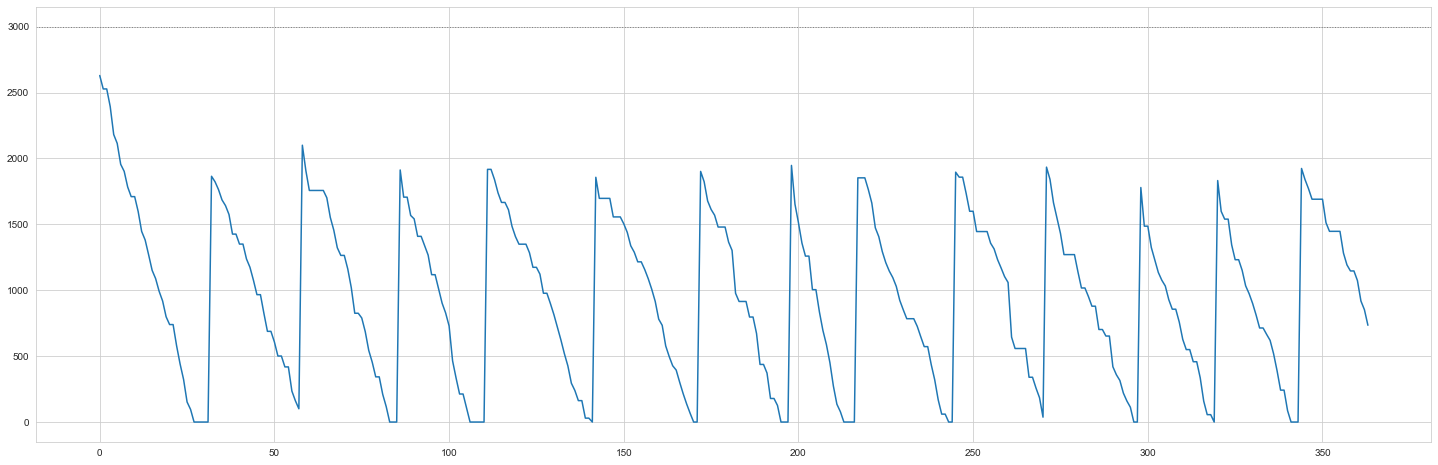

In [54]:
data = cc_monte_carlo_ray(Product(1), 2000, 700)
plt.figure(figsize=(25,8))
plt.plot(data['inv_level'])
plt.axhline(3000, linewidth=1, color='gray', linestyle=":")
plt.show()

In [55]:
data = cc_monte_carlo_ray(Product(1), 2000, 700)
len(data['orders'])

12

In [50]:
def cc_mc_simulation(product, q, r, num_simulations=50):
    profit_list = []
    order_lost_list = []
    for sim in range(num_simulations):
        data = cc_monte_carlo_ray(product, q, r)
        # calculating the profit
        profit = calculate_profit(data, product)
        profit_list.append(profit)
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        order_lost_list.append(unsold_orders/total_demand)
        
    return profit_list, order_lost_list

In [65]:
p_list, o_list = cc_mc_simulation(Product(1), 2000, 700, 1000)
print([np.mean(p_list), np.std(p_list)])

[109144.11047713607, 8480.879452736792]


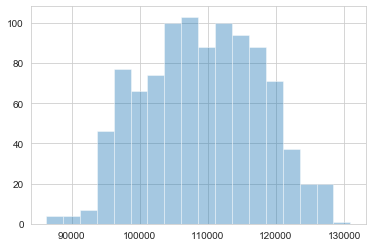

In [66]:
sns.distplot(p_list, kde=False)
plt.show()

In [52]:
def continuous_review(product, q_guess, r_guess):
    q_low = q_guess - 1000
    q_high = q_guess + 1000
    q_range = [i for i in range(int(q_low), int(q_high), 10)]
    
    r_low = r_guess - 300
    r_high = r_guess + 300
    r_range = [i for i in range(int(r_low), int(r_high), 10)]
    
    review_dict = {}
    
    for q in q_range:
        for r in r_range:
            p_list, o_list = cc_mc_simulation(product, q, r)
            review_dict[(q,r)] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list),
                                 np.mean(o_list))
    return review_dict

In [71]:
cc_review = continuous_review(Product(1), 2000, 700)

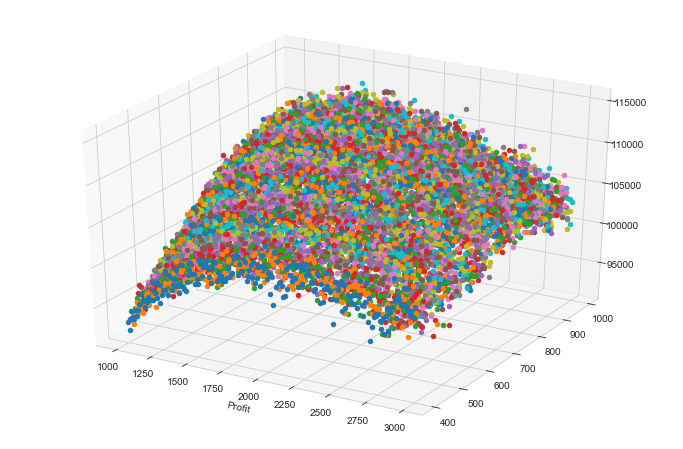

In [72]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

for key, val in cc_review.items():
    ax.scatter(key[0], key[1], val[0], marker='o')

ax.set_xlabel('Order Quantity')
ax.set_ylabel('Reorder Point')
ax.set_zlabel('Profit')

plt.show()

In [73]:
max(review.items(), key=operator.itemgetter(1))

(1305,
 (321990.2076035037,
  271827.6181477799,
  370134.9400871076,
  29703.141614876797,
  0.07345414808262367))

In [74]:
idx = ['Order Quantity', 'Reorder Point', 'Expected Profit', 'Profit Standard Deviation', 'Proportion of Lost Orders']

review = continuous_review(Product(1), 2000, 700)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))

review = continuous_review(Product(2), 22500, 2600)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))

review = continuous_review(Product(3), 3500, 2500)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))

review = continuous_review(Product(4), 1150, 1150)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))

In [75]:
df_cc_review = pd.DataFrame(
    {'1': [prod_review_1[0][0], prod_review_1[0][1], prod_review_1[1][0], prod_review_1[1][3], prod_review_1[1][4]],
    '2': [prod_review_2[0][0], prod_review_2[0][1], prod_review_2[1][0], prod_review_2[1][3], prod_review_2[1][4]],
    '3': [prod_review_3[0][0], prod_review_3[0][1], prod_review_3[1][0], prod_review_3[1][3], prod_review_3[1][4]],
    '4': [prod_review_4[0][0], prod_review_4[0][1], prod_review_4[1][0], prod_review_4[1][3], prod_review_4[1][4]],
    })

In [76]:
df_cc_review.index = idx
df_cc_review

,1,2,3,4
Order Quantity,1500.000000,22350.000000,2680.000000,1290.000000
Reorder Point,800.000000,2860.000000,2680.000000,1160.000000
Expected Profit,114601.529149,490909.939427,202197.128409,395430.588345
Profit Standard Deviation,7362.517582,4488.386915,7879.314644,47886.148341
Proportion of Lost Orders,0.043754,0.054122,0.017798,0.018872


In [77]:
p_list, o_list = cc_mc_simulation(Product(2), 25513, 2638, 10000)
print([np.mean(p_list), np.std(p_list)])

[467686.00938817865, 5336.8193227638185]


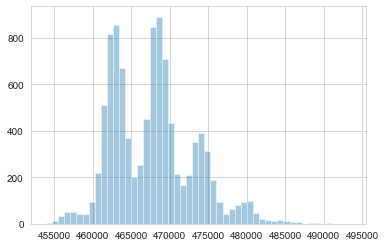

In [78]:
sns.distplot(p_list, kde=False)
plt.show()

In [79]:
np.mean(o_list)

0.05513003206305032

## Find the optimum value

### Periodic Review

In [58]:
product = Product(4)
def function(args):
    M = args[0][0]
    p_list, o_list = mc_simulation(product, M, 500)
    
    print(f' M: {M}, Profit : ${np.mean(p_list):.2f}')
    return -np.mean(p_list)

In [59]:
bounds = [{'name':'M', 'type':'discrete', 'domain': range(10,10000)}]

Op = BayesianOptimization(f = function,
                         domain = bounds,
                         model_type = 'GP',
                         acquisition_type = 'EI',
                         exact_feval = False,
                         maximize = False,
                         normalize_Y = False)

Op.run_optimization(max_iter=100)

 M: 7032.0, Profit : $22148.74
 M: 2540.0, Profit : $268316.54
 M: 7085.0, Profit : $19877.30
 M: 2824.0, Profit : $257948.74
 M: 7225.0, Profit : $15426.39
 M: 7084, Profit : $18989.96
 M: 2470, Profit : $277865.24
 M: 2373, Profit : $280393.06
 M: 2080, Profit : $297955.34
 M: 1060, Profit : $314649.39
 M: 1373, Profit : $321394.78
 M: 1405, Profit : $321914.95
 M: 1407, Profit : $323039.28
 M: 1413, Profit : $321432.29
 M: 1410, Profit : $319862.54
 M: 1403, Profit : $320163.20
 M: 1400, Profit : $320834.31
 M: 1400, Profit : $322208.82


In [60]:
Op.x_opt

array([1407.])

In [ ]:
## Continuous Review

In [48]:
def optimizer(args):
    
    q = args[0][0]
    r = args[0][1]
    
    product = Product(4)
    p_list, o_list = cc_mc_simulation(product, q, r, 500)
    
    print(f' q : {q}, r : {r}, Profit : ${np.mean(p_list):.2f}')
    
    return -np.mean(p_list)

In [53]:
from GPyOpt.methods import BayesianOptimization

bounds = [{'name':'Q', 'type':'discrete', 'domain': range(10,5000)},
         {'name': 'r', 'type':'discrete', 'domain': range(10,5000)}]

Op = BayesianOptimization(f = optimizer,
                         domain = bounds,
                         model_type = 'GP',
                         acquisition_type = 'EI',
                         exact_feval = False,
                         maximize = False,
                         normalize_Y = False)

Op.run_optimization(max_iter=100)

 q : 148.0, r : 3960.0, Profit : $143729.50
 q : 4099.0, r : 4417.0, Profit : $140499.57
 q : 892.0, r : 532.0, Profit : $313296.10
 q : 141.0, r : 3589.0, Profit : $140563.93
 q : 2085.0, r : 4490.0, Profit : $182618.43
 q : 2468, r : 4433, Profit : $172811.21
 q : 1120, r : 3050, Profit : $286438.54
 q : 1494, r : 638, Profit : $348711.67
 q : 887, r : 505, Profit : $315059.00
 q : 4335, r : 1071, Profit : $317331.64
 q : 3213, r : 3684, Profit : $190475.83
 q : 1817, r : 3068, Profit : $266874.08
 q : 4326, r : 1059, Profit : $320217.22
 q : 1492, r : 629, Profit : $348937.24
 q : 1939, r : 950, Profit : $364769.98
 q : 2590, r : 921, Profit : $351670.25
 q : 3656, r : 10, Profit : $268529.64
 q : 1912, r : 1441, Profit : $353126.70
 q : 2066, r : 692, Profit : $349660.74
 q : 3394, r : 1336, Profit : $319943.22
 q : 1945, r : 1070, Profit : $365691.28
 q : 4999, r : 124, Profit : $290587.76
 q : 1753, r : 1066, Profit : $371791.27
 q : 1570, r : 1149, Profit : $372300.97
 q : 4999,

In [54]:
Op.x_opt

array([1570., 1149.])

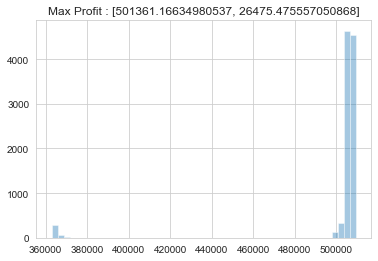

In [61]:
p_list, o_list = cc_mc_simulation(Product(2), 21150, 4036, 10000)

sns.distplot(p_list, kde=False)
plt.title(f'Max Profit : {[np.mean(p_list), np.std(p_list)]}')

plt.show()

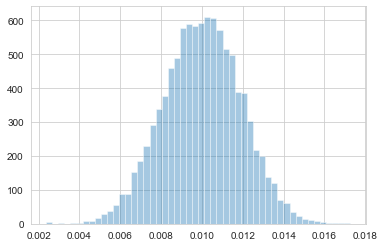

In [63]:
sns.distplot(o_list, kde=False)

In [62]:
np.std(o_list)

0.0019010505456078287

## Safety Stock

In [67]:
for i in range(4):
    print(f"Expected Demand Product {i+1} during lead time - {summary['Lead Time'].iloc[i] * np.mean(demand[i+1]):.2f} \n")

Expected Demand Product 1 during lead time - 705.00 

Expected Demand Product 2 during lead time - 3891.31 

Expected Demand Product 3 during lead time - 2265.84 

Expected Demand Product 4 during lead time - 784.79 



In [68]:
demand_lead_time = []
for i in range(4):
    demand_lead_time.append(summary['Lead Time'].iloc[i] * np.mean(demand[i+1]))

In [69]:
r_star = [812, 4036, 2877, 1221]

for i in range(4):
    print(f'Safety Stock for Product {i} is : {round(r_star[i] - demand_lead_time[i], 0)}')

Safety Stock for Product 0 is : 107.0
Safety Stock for Product 1 is : 145.0
Safety Stock for Product 2 is : 611.0
Safety Stock for Product 3 is : 436.0
